# <span style="color:brown"> Testing VAE

In [1]:
import os
import sys
import datetime as dt

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

%matplotlib inline

## Loading datasets

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
data = input_data.read_data_sets('datasets/MNIST/', one_hot=True)

Extracting datasets/MNIST/train-images-idx3-ubyte.gz
Extracting datasets/MNIST/train-labels-idx1-ubyte.gz
Extracting datasets/MNIST/t10k-images-idx3-ubyte.gz
Extracting datasets/MNIST/t10k-labels-idx1-ubyte.gz


## Hyperparameters

In [3]:
# Inputs
image_size = 28
image_channel = 1
image_size_flat = image_size * image_size * image_channel

# Network
latent_dim = 32
hidden_dim = 512

# Training
learning_rate = 1e-3
batch_size = 24
iterations = 10000
save_interval = 50
record_interval = 1000

## <span style="color:#008899"> Building the Model

In [4]:
tf.reset_default_graph()

X = tf.placeholder(tf.float32, shape=[None, image_size_flat])

### <span style="color:#505050"> Helper functions

In [5]:
def weight(shape, name):
    initial = tf.truncated_normal(shape=shape, mean=0, stddev=0.1)
    return tf.Variable(initial, name=name)

def bias(shape, name):
    initial = tf.zeros(shape=[shape])
    return tf.Variable(initial, name=name)

def dense(X, W, b):
    return tf.matmul(X, W) + b

def plot_images(imgs, size=28, name=None):
    grid = int(np.sqrt(len(imgs)))
    fig, axes = plt.subplots(grid, grid)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)
    if name:
        plt.suptitle(name)
    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i].reshape([size, size]), cmap='binary', interpolation='bicubic')
        ax.set_xticks([])
        ax.set_yticks([])
    plt.show()

### <span style="color:#666">_the encoder_

In [6]:
def encoder(X):
    with tf.name_scope('encoder'):
        # hidden encoder
        W_enc = weight(shape=[image_size_flat, hidden_dim], name='W_enc')
        b_enc = bias(shape=hidden_dim, name='b_enc')
        h_enc = tf.nn.tanh(dense(X, W_enc, b_enc))
        # mean
        W_mean = weight(shape=[hidden_dim, latent_dim], name='W_mean')
        b_mean = bias(shape=latent_dim, name='b_mean')
        mean = dense(h_enc, W_mean, b_mean)
        # stddev
        W_std = weight(shape=[hidden_dim, latent_dim], name='W_std')
        b_std = bias(shape=latent_dim, name='b_std')
        stddev = dense(h_enc, W_std, b_std)
        # randomness
        noise = tf.random_normal(shape=[1, latent_dim])
        encoded = mean + tf.multiply(noise, tf.exp(0.5 * stddev))  # mean + (noise * exp(1/2*stddev))
        return encoded, mean, stddev

### <span style="color:#666">_the decoder_

In [7]:
def decoder(encoded):
    with tf.name_scope('decoder'):
        # hidden decoder
        W_dec = weight(shape=[latent_dim, hidden_dim], name='W_dec')
        b_dec = bias(shape=hidden_dim, name='b_dec')
        h_dec = tf.nn.tanh(dense(encoded, W_dec, b_dec))
        # reconstruction
        W_rec = weight(shape=[hidden_dim, image_size_flat], name='W_rec')
        b_rec = bias(shape=image_size_flat, name='b_rec')
        decoded = tf.nn.sigmoid(dense(h_dec, W_rec, b_rec))
        return decoded

In [8]:
encoded, mean, stddev = encoder(X)
decoded = decoder(encoded)

## Reconstruction loss, KL-Divergence & Optimizer

In [9]:
# rec_loss = tf.reduce_sum(X*tf.log(decoded + 1e-9) + (1 - X) * tf.log(1 - decoded+1e-9), reduction_indices=1)
# kl_term = -0.5 * tf.reduce_sum(1 + 2 * stddev - tf.pow(mean, 2) - tf.exp(2*stddev), reduction_indices=1)
# loss = tf.reduce_mean(rec_loss - kl_term)

rec_loss = tf.reduce_sum(tf.squared_difference(decoded, X), 1)
kl_term = -0.5 * tf.reduce_sum(1.0 + 2.0 * stddev - tf.square(mean) - tf.exp(2.0 * stddev), 1)
loss = tf.reduce_mean(rec_loss + kl_term)

optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = optimizer.minimize(loss)

print(rec_loss)
print(kl_term)
print(loss)

Tensor("Sum:0", shape=(?,), dtype=float32)
Tensor("mul_2:0", shape=(?,), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)


## Tensorflow `Session` and initializing global variables

In [10]:
sess = tf.Session()
init = tf.global_variables_initializer()
sess.run(init)

### Tensorboard

In [11]:
tensorbaord_dir = 'tensorboard/'
logdir = os.path.join(tensorbaord_dir, 'log/')
save_path = 'models/'

# saver and writer object
saver = tf.train.Saver()
writer = tf.summary.FileWriter(logdir=logdir, graph=sess.graph)

# load last checkpoint
if tf.gfile.Exists(save_path):
    if len(os.listdir(save_path)) > 1:
        saver.restore(sess=sess, save_path=save_path)
else:
    tf.gfile.MakeDirs(save_path)

# Summary
tf.summary.histogram('log_likelihood', rec_loss)
tf.summary.histogram('kl_term', kl_term)
tf.summary.scalar('loss', loss)
tf.summary.scalar('log_likelihood_mean', tf.reduce_mean(rec_loss))
tf.summary.scalar('kl_term_mean', tf.reduce_mean(kl_term))
rec_img = tf.reshape(decoded, [batch_size, image_size, image_size, image_channel])
tf.summary.image('rec_img', rec_img, max_outputs=4)
merged = tf.summary.merge_all()

## <span style="color:#008899"> Training the model

In [12]:
train_start = dt.datetime.now()
for i in range(iterations):
    X_batch = np.round(data.train.next_batch(batch_size)[0])
    _, _loss, _rec_loss, _kl_term = sess.run([train_step, loss, rec_loss, kl_term], feed_dict={X:X_batch})
    if i % save_interval == 0:
        saver.save(sess=sess, save_path=save_path)
        summary = sess.run(merged, feed_dict={X:X_batch})
        writer.add_summary(summary=summary,global_step=i)
    sys.stdout.write('\rIter: {:,}\tLoss: {:.2f}\tReconstruction: {:.2f}\tK-L: {:.2f}\tTrain time: {}'.format(
                        i+1, _loss, np.mean(_rec_loss), np.mean(_kl_term), dt.datetime.now()-train_start))

Iter: 10,000	Loss: 65.06	Reconstruction: 50.68	K-L: 14.38	Train time: 0:03:41.969241

## <span style="color:#889900"> Testing the model

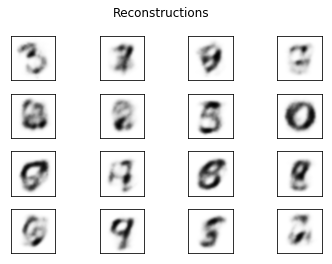

In [13]:
randoms = [np.random.normal(0, 1, latent_dim) for _ in range(16)]
imgs = sess.run(decoded, feed_dict = {encoded: randoms})
plot_images(imgs, name='Reconstructions')